# **Import**

In [14]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"Đã thêm project root: {project_root}")

# Data processing
import pandas as pd
from typing import Dict, Tuple, Any, Optional, List
from datetime import datetime, timedelta
from websocket import create_connection
from TradingviewData import TradingViewData, Interval

# Components
from src.core.trading_engine import TradingEngine
from src.strategies.base_strategy import BaseStrategy
from src.strategies.sma_crossover import SMACrossoverStrategy
from src.strategies.rsi_strategy import RSIStrategy
from src.strategies.macd_strategy import MACDStrategy
from src.utils.config_manager import ConfigManager

# Visualize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objects import Candlestick

# from lightweight_charts import Chart, JupyterChart
# from time import sleep

# **Data**

In [2]:
intervals = ['daily', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'min_1', 
'min_15', 'min_3', 'min_30', 'min_45', 'min_5', 'monthly', 'weekly']

In [120]:
# Get data from TradingView
def get_data(tickers, interval, n_bars):
    request = TradingViewData()
    for ticker, exchange in tickers.items():
        data = request.get_hist(symbol=ticker, exchange=exchange, interval=interval, n_bars=n_bars)
        data.to_csv(f'data/{ticker}-{exchange}-{interval}-{n_bars}.csv')

tickers = {'BTCUSD': 'Bitstamp', 'ETHUSD': 'Bitstamp'}
interval = Interval.hour_4
n_bars = 1000

get_data(tickers, interval, n_bars)

In [121]:
# Load data
# combine all data using multiindex
import pandas as pd
import os
import glob

# Load data
files = glob.glob(f'data/*-{n_bars}.csv')
df = pd.concat([pd.read_csv(file) for file in files])
df.datetime = pd.to_datetime(df.datetime)
df.set_index('datetime', inplace=True)

# select symbol
symbol = 'Bitstamp:BTCUSD'
df = df[df.symbol == symbol][-100:]

In [122]:
# Visualize
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

fig.add_trace(go.Candlestick(x=df.index,
                    open=df.open,
                    high=df.high,
                    low=df.low,
                    close=df.close,
                    ), row=1, col=1)
set_ylim = (df.low.min(), df.high.max() * 1.05)

fig.add_trace(go.Bar(x=df.index,
                    y=df.volume,
                    ), row=2, col=1)

fig.update_layout(title=f'{symbol}',
                  yaxis_range=(set_ylim[0], set_ylim[1]),
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2025-07-15 23:00:00 to 2025-08-01 11:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  100 non-null    object 
 1   open    100 non-null    float64
 2   high    100 non-null    float64
 3   low     100 non-null    float64
 4   close   100 non-null    float64
 5   volume  100 non-null    float64
dtypes: float64(5), object(1)
memory usage: 5.5+ KB


# **Indicators**

### SMA

In [35]:
def calculate_sma(prices: pd.Series, window: int) -> pd.Series:
    """
    Calculate Simple Moving Average
    
    Args:
        prices: Price series (typically closing prices)
        window: Window size for SMA calculation
        
    Returns:
        SMA series
    """
    return prices.rolling(window=window).mean()

def calculate_sma_crossover(prices: pd.Series, short_window: int, long_window: int) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate SMA crossover components
    
    Args:
        prices: Price series (typically closing prices)
        short_window: Short SMA window
        long_window: Long SMA window
        
    Returns:
        Tuple of (short_sma, long_sma)
    """
    short_sma = calculate_sma(prices, short_window)
    long_sma = calculate_sma(prices, long_window)
    
    return short_sma, long_sma

def calculate_sma_components(prices: pd.Series, short_window: int, long_window: int) -> Dict[str, pd.Series]:
    """
    Calculate SMA crossover components and return as dictionary
    
    Args:
        prices: Price series (typically closing prices)
        short_window: Short SMA window
        long_window: Long SMA window
        
    Returns:
        Dictionary containing SMA components
    """
    short_sma, long_sma = calculate_sma_crossover(prices, short_window, long_window)
    
    return {
        'short_sma': short_sma,
        'long_sma': long_sma,
        'sma_diff': short_sma - long_sma
    }

### MACD

In [8]:
def calculate_macd(prices: pd.Series, fast_period: int = 12, 
                  slow_period: int = 26, signal_period: int = 9) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Calculate MACD indicator components
    
    Args:
        prices: Price series (typically closing prices)
        fast_period: Period for fast EMA (default: 12)
        slow_period: Period for slow EMA (default: 26)
        signal_period: Period for signal line EMA (default: 9)
        
    Returns:
        Tuple of (macd_line, signal_line, histogram)
    """
    # Calculate exponential moving averages
    ema_fast = prices.ewm(span=fast_period).mean()
    ema_slow = prices.ewm(span=slow_period).mean()
    
    # MACD line
    macd_line = ema_fast - ema_slow
    
    # Signal line
    signal_line = macd_line.ewm(span=signal_period).mean()
    
    # Histogram
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram


def calculate_macd_components(prices: pd.Series, fast_period: int = 12, 
                            slow_period: int = 26, signal_period: int = 9) -> dict:
    """
    Calculate all MACD components and return as dictionary
    
    Args:
        prices: Price series (typically closing prices)
        fast_period: Period for fast EMA (default: 12)
        slow_period: Period for slow EMA (default: 26)
        signal_period: Period for signal line EMA (default: 9)
        
    Returns:
        Dictionary containing all MACD components
    """
    macd_line, signal_line, histogram = calculate_macd(prices, fast_period, slow_period, signal_period)
    
    return {
        'macd_line': macd_line,
        'signal_line': signal_line,
        'histogram': histogram,
        'zero_line': pd.Series([0] * len(prices), index=prices.index)
    } 

### RSI

In [9]:
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    """
    Calculate RSI (Relative Strength Index) indicator
    
    Args:
        prices: Price series (typically closing prices)
        period: Period for RSI calculation (default: 14)
        
    Returns:
        RSI series
    """
    delta = prices.diff()
    
    # Separate gains and losses
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    # Calculate average gains and losses
    avg_gains = gains.rolling(window=period).mean()
    avg_losses = losses.rolling(window=period).mean()
    
    # Calculate RS and RSI
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))
    
    return rsi


def calculate_rsi_components(prices: pd.Series, period: int = 14, 
                           overbought_threshold: int = 70, 
                           oversold_threshold: int = 30) -> Dict[str, pd.Series]:
    """
    Calculate RSI and related components
    
    Args:
        prices: Price series (typically closing prices)
        period: Period for RSI calculation (default: 14)
        overbought_threshold: Overbought level (default: 70)
        oversold_threshold: Oversold level (default: 30)
        
    Returns:
        Dictionary containing RSI and threshold lines
    """
    rsi = calculate_rsi(prices, period)
    
    return {
        'rsi': rsi,
        'overbought_line': pd.Series([overbought_threshold] * len(prices), index=prices.index),
        'oversold_line': pd.Series([oversold_threshold] * len(prices), index=prices.index)
    } 

### Bollinger_bands

In [10]:
def calculate_bollinger_bands(prices: pd.Series, period: int = 20, 
                            std_dev: int = 2) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Calculate Bollinger Bands
    
    Args:
        prices: Price series (typically closing prices)
        period: Period for SMA calculation (default: 20)
        std_dev: Number of standard deviations (default: 2)
        
    Returns:
        Tuple of (upper_band, middle_band, lower_band)
    """
    middle_band = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()
    upper_band = middle_band + (std * std_dev)
    lower_band = middle_band - (std * std_dev)
    
    return upper_band, middle_band, lower_band


def calculate_bollinger_components(prices: pd.Series, period: int = 20, 
                                 std_dev: int = 2) -> Dict[str, pd.Series]:
    """
    Calculate Bollinger Bands components and return as dictionary
    
    Args:
        prices: Price series (typically closing prices)
        period: Period for SMA calculation (default: 20)
        std_dev: Number of standard deviations (default: 2)
        
    Returns:
        Dictionary containing Bollinger Bands components
    """
    upper_band, middle_band, lower_band = calculate_bollinger_bands(prices, period, std_dev)
    
    return {
        'upper_band': upper_band,
        'middle_band': middle_band,
        'lower_band': lower_band,
        'bandwidth': (upper_band - lower_band) / middle_band,
        'percent_b': (prices - lower_band) / (upper_band - lower_band)
    } 

# **Strategies**

### Base strategy

In [11]:
def update_position(symbol: str, quantity: float, price: float):
    """Update strategy's position tracking"""
    if symbol not in positions:
        positions[symbol] = {
            'quantity': 0,
            'avg_price': 0,
            'total_cost': 0
        }
    
    pos = positions[symbol]
    
    if quantity > 0:  # Buy
        total_quantity = pos['quantity'] + quantity
        total_cost = pos['total_cost'] + (quantity * price)
        pos['quantity'] = total_quantity
        pos['total_cost'] = total_cost
        pos['avg_price'] = total_cost / total_quantity
    else:  # Sell
        pos['quantity'] += quantity  # quantity is negative for sell
        if pos['quantity'] <= 0:
            # Position closed
            pos['quantity'] = 0
            pos['avg_price'] = 0
            pos['total_cost'] = 0
    
def get_position(symbol: str) -> Optional[Dict[str, Any]]:
    """Get current position for a symbol"""
    return positions.get(symbol)

def has_position(symbol: str) -> bool:
    """Check if strategy has a position in symbol"""
    return symbol in positions and positions[symbol]['quantity'] > 0

def calculate_pnl(symbol: str, current_price: float) -> float:
    """Calculate unrealized P&L for a position"""
    if not has_position(symbol):
        return 0.0
    
    position = positions[symbol]
    return (current_price - position['avg_price']) * position['quantity']

def reset():
    """Reset strategy state"""
    positions = {}
    signals = {}
    logger.info(f"Reset strategy: {name}")

def get_summary() -> Dict[str, Any]:
    """Get strategy summary"""
    return {
        'name': name,
        'positions': positions,
        'total_positions': len([p for p in positions.values() if p['quantity'] > 0])
    }

In [12]:
df.head()

,symbol,open,high,low,close,volume
datetime,,,,,,
2023-01-01 07:00:00,Bitstamp:BTCUSD,16530.0,16546.0,16507.0,16522.0,59.436695
2023-01-01 11:00:00,Bitstamp:BTCUSD,16523.0,16535.0,16496.0,16517.0,64.831896
2023-01-01 15:00:00,Bitstamp:BTCUSD,16517.0,16544.0,16498.0,16544.0,74.120038
2023-01-01 19:00:00,Bitstamp:BTCUSD,16544.0,16560.0,16535.0,16546.0,67.301095
2023-01-01 23:00:00,Bitstamp:BTCUSD,16546.0,16612.0,16546.0,16597.0,99.620520


In [13]:
symbol = 'Bitstamp:BTCUSD'
smacrossover = SMACrossoverStrategy(short_window=20, long_window=50)

# Try to call and print the output to debug
result = calculate_sma_components(df.close, smacrossover.short_window, smacrossover.long_window)

# If result is a tuple/list, get the first two elements
short_sma, long_sma = result['short_sma'], result['long_sma']
print(f"Short SMA (first 5):\n{short_sma.tail()}")
print(f"Long SMA (first 5):\n{long_sma.tail()}")


TypeError: SMACrossoverStrategy.__init__() got an unexpected keyword argument 'short_window'

### SMA Crossover

In [ ]:
class SMACrossoverStrategy(BaseStrategy):
    """Simple Moving Average Crossover Strategy"""
    
    def __init__(self, short_window: int, long_window: int):
        """Initialize SMA Crossover strategy"""
        # super().__init__("sma_crossover")
        
        # Strategy parameters
        self.short_window = short_window
        self.long_window = long_window
        
        # Validate parameters
        if self.short_window >= self.long_window:
            raise ValueError("Short window must be less than long window")
        
        print(f"SMA Crossover Strategy initialized: {self.short_window}/{self.long_window}")
        # logger.info(f"SMA Crossover Strategy initialized: {self.short_window}/{self.long_window}")
    
    def generate_signals(self, historical_data: pd.DataFrame, current_data: pd.Series) -> Dict[str, str]:
        """
        Generate trading signals based on SMA crossover
        
        Args:
            historical_data: Historical market data up to current point (OHLCV or close-only)
            current_data: Current day's market data
            
        Returns:
            Dict mapping symbol to signal ('buy', 'sell', 'hold')
        """
        signals = {}
        
        # Legacy close-only data structure
        for symbol in historical_data.symbol.unique():
            # if isinstance(symbol, str) and not symbol.endswith('_SMA'):
                # Get historical price data for this symbol
            symbol_data = historical_data[df.symbol==symbol]['close'].dropna()
            # print(symbol_data, symbol)
            
            if len(symbol_data) >= self.long_window:
                signal = self._generate_signal_for_symbol(symbol_data, symbol)
                signals[symbol] = signal
            else:
                signals[symbol] = 'hold'  # Not enough data
        
        return signals
    
    def _generate_signal_for_symbol(self, price_data: pd.Series, symbol: str) -> str:
        """Generate signal for a single symbol"""
        if len(price_data) < self.long_window:
            return 'hold'  # Not enough data
        
        # Calculate SMAs
        short_sma, long_sma = calculate_sma_crossover(price_data, self.short_window, self.long_window)

        # Get current and previous values
        current_short = short_sma.iloc[-1]
        current_long = long_sma.iloc[-1]
        prev_short = short_sma.iloc[-2] if len(short_sma) > 1 else current_short
        prev_long = long_sma.iloc[-2] if len(long_sma) > 1 else current_long
        
        # Check for crossover
        current_cross_up = current_short > current_long
        prev_cross_up = prev_short > prev_long
        
        # Generate signals
        if current_cross_up and not prev_cross_up:
            # Golden cross (short SMA crosses above long SMA)
            # logger.info(f"Golden cross detected for {symbol}: {current_short:.2f} > {current_long:.2f}")
            print(f"Golden cross detected for {symbol}: {current_short:.2f} > {current_long:.2f}")
            return 'buy'
        elif not current_cross_up and prev_cross_up:
            # Death cross (short SMA crosses below long SMA)
            # logger.info(f"Death cross detected for {symbol}: {current_short:.2f} < {current_long:.2f}")
            print(f"Death cross detected for {symbol}: {current_short:.2f} < {current_long:.2f}")
            return 'sell'
        else:
            return 'hold'
    
    def validate_config(self) -> bool:
        """Validate strategy configuration"""
        if self.short_window <= 0 or self.long_window <= 0:
            logger.error("SMA windows must be positive")
            return False
        
        if self.short_window >= self.long_window:
            logger.error("Short window must be less than long window")
            return False
        
        return True
    
    def get_indicators(self, price_data: pd.Series) -> Dict[str, pd.Series]:
        """Get strategy indicators for the given price data"""
        if len(price_data) < self.long_window:
            return {}
        
        # Calculate SMA components
        result = calculate_sma_components(price_data, self.short_window, self.long_window)
                
        return {
            f'{self.short_window}_SMA': result['short_sma'],
            f'{self.long_window}_SMA': result['long_sma'],
            f'diff': result['sma_diff']
        }
    
    def get_summary(self) -> Dict[str, Any]:
        """Get strategy summary"""
        return {
            'name': self.name,
            'strategy_type': 'SMA Crossover',
            'short_window': self.short_window,
            'long_window': self.long_window,
            'description': f'SMA Crossover with {self.short_window}/{self.long_window} periods'
        } 

### RSI

# **Optimizing**

In [ ]:
class ParameterGrid:
    """Defines parameter grids for different strategy types"""
    
    def __init__(self):
        """Initialize parameter grids for different strategies"""
        self.grids = self._initialize_grids()
    
    def _initialize_grids(self) -> Dict[str, Dict[str, List]]:
        """Initialize parameter grids for each strategy type"""
        return {
            'sma_crossover': {
                'short_window': [5, 10, 15, 20, 25, 30],
                'long_window': [30, 40, 50, 60, 70, 80, 90, 100]
            },
            'rsi': {
                'period': [10, 14, 20, 30],
                'oversold': [20, 25, 30, 35],
                'overbought': [65, 70, 75, 80]
            },
            'macd': {
                'fast_period': [8, 10, 12, 15, 20],
                'slow_period': [20, 26, 30, 35, 40],
                'signal_period': [7, 9, 12, 15]
            },
            'bollinger_bands': {
                'period': [10, 15, 20, 30],
                'std_dev': [1.5, 2.0, 2.5, 3.0]
            }
        }
    
    def get_parameter_combinations(self, strategy_type: str) -> List[Dict[str, Any]]:
        """
        Get all parameter combinations for a strategy type
        
        Args:
            strategy_type: Type of strategy ('sma_crossover', 'rsi', 'macd', etc.)
            
        Returns:
            List of parameter dictionaries
        """
        if strategy_type not in self.grids:
            logger.warning(f"No parameter grid defined for strategy type: {strategy_type}")
            return []
        
        grid = self.grids[strategy_type]
        param_names = list(grid.keys())
        param_values = list(grid.values())
        
        # Generate all combinations
        combinations = list(itertools.product(*param_values))
        
        # Convert to list of dictionaries
        param_combinations = []
        for combo in combinations:
            param_dict = dict(zip(param_names, combo))
            param_combinations.append(param_dict)
        
        logger.info(f"Generated {len(param_combinations)} parameter combinations for {strategy_type}")
        return param_combinations
    
    def get_filtered_combinations(self, strategy_type: str, 
                                filters: Dict[str, Any] = None) -> List[Dict[str, Any]]:
        """
        Get parameter combinations with optional filters
        
        Args:
            strategy_type: Type of strategy
            filters: Dictionary of filters to apply (e.g., {'short_window': [10, 20]})
            
        Returns:
            Filtered list of parameter dictionaries
        """
        combinations = self.get_parameter_combinations(strategy_type)
        
        if not filters:
            return combinations
        
        filtered_combinations = []
        for combo in combinations:
            include = True
            for param, allowed_values in filters.items():
                if param in combo and combo[param] not in allowed_values:
                    include = False
                    break
            if include:
                filtered_combinations.append(combo)
        
        logger.info(f"Filtered to {len(filtered_combinations)} combinations")
        return filtered_combinations
    
    def add_custom_grid(self, strategy_type: str, parameters: Dict[str, List]):
        """
        Add custom parameter grid for a strategy type
        
        Args:
            strategy_type: Name of the strategy type
            parameters: Dictionary of parameter names to value lists
        """
        self.grids[strategy_type] = parameters
        logger.info(f"Added custom parameter grid for {strategy_type}")
    
    def get_grid_info(self, strategy_type: str) -> Dict[str, Any]:
        """
        Get information about parameter grid for a strategy type
        
        Args:
            strategy_type: Type of strategy
            
        Returns:
            Dictionary with grid information
        """
        if strategy_type not in self.grids:
            return {}
        
        grid = self.grids[strategy_type]
        total_combinations = 1
        for values in grid.values():
            total_combinations *= len(values)
        
        return {
            'parameters': list(grid.keys()),
            'parameter_ranges': grid,
            'total_combinations': total_combinations
        }
    
    def validate_parameters(self, strategy_type: str, parameters: Dict[str, Any]) -> bool:
        """
        Validate if parameters are within the defined grid
        
        Args:
            strategy_type: Type of strategy
            parameters: Parameters to validate
            
        Returns:
            True if parameters are valid
        """
        if strategy_type not in self.grids:
            return False
        
        grid = self.grids[strategy_type]
        
        for param, value in parameters.items():
            if param in grid and value not in grid[param]:
                logger.warning(f"Parameter {param}={value} not in grid for {strategy_type}")
                return False
        
        return True
    
    def get_parameter_bounds(self, strategy_type: str) -> Dict[str, Tuple]:
        """
        Get parameter bounds for a strategy type
        
        Args:
            strategy_type: Type of strategy
            
        Returns:
            Dictionary of parameter bounds (min, max)
        """
        if strategy_type not in self.grids:
            return {}
        
        grid = self.grids[strategy_type]
        bounds = {}
        
        for param, values in grid.items():
            if values:
                bounds[param] = (min(values), max(values))
        
        return bounds 

In [ ]:
class StrategyOptimizer:
    """Optimizes strategy parameters using risk management metrics"""
    
    def __init__(self, config: ConfigManager):
        """Initialize strategy optimizer"""
        self.config = config
        self.backtest_engine = BacktestEngine(config)
        self.parameter_grid = ParameterGrid()
        
        # Strategy factory
        self.strategy_factory = {
            'sma_crossover': SMACrossoverStrategy,
            'rsi': RSIStrategy,
            'macd': MACDStrategy
        }
        
        # Optimization results
        self.optimization_results = {}
        self.best_parameters = {}
        
        logger.info("Strategy optimizer initialized")
    
    def optimize_strategy(self, strategy_type: str, 
                         start_date: str, end_date: str,
                         optimization_metric: str = 'sharpe_ratio',
                         max_combinations: int = None,
                         filters: Dict[str, Any] = None,
                         use_parallel: bool = True) -> Dict[str, Any]:
        """
        Optimize parameters for a specific strategy type
        
        Args:
            strategy_type: Type of strategy to optimize
            start_date: Start date for optimization period
            end_date: End date for optimization period
            optimization_metric: Metric to optimize ('sharpe_ratio', 'total_return', 'profit_factor', etc.)
            max_combinations: Maximum number of parameter combinations to test
            filters: Optional filters for parameter combinations
            use_parallel: Whether to use parallel processing
            
        Returns:
            Dictionary containing optimization results
        """
        logger.info(f"Starting optimization for {strategy_type}")
        
        # Get parameter combinations
        combinations = self.parameter_grid.get_filtered_combinations(strategy_type, filters)
        
        if max_combinations and len(combinations) > max_combinations:
            # Sample combinations if too many
            combinations = np.random.choice(combinations, max_combinations, replace=False).tolist()
            logger.info(f"Sampled {max_combinations} combinations from {len(combinations)} total")
        
        if not combinations:
            logger.error(f"No parameter combinations available for {strategy_type}")
            return {}
        
        # Run optimization
        if use_parallel and len(combinations) > 10:
            results = self._optimize_parallel(strategy_type, combinations, start_date, end_date, optimization_metric)
        else:
            results = self._optimize_sequential(strategy_type, combinations, start_date, end_date, optimization_metric)
        
        # Find best parameters
        best_params = self._find_best_parameters(results, optimization_metric)
        
        # Store results
        self.optimization_results[strategy_type] = {
            'results': results,
            'best_parameters': best_params,
            'optimization_metric': optimization_metric,
            'total_combinations': len(combinations),
            'tested_combinations': len(results)
        }
        
        self.best_parameters[strategy_type] = best_params
        
        logger.info(f"Optimization completed for {strategy_type}")
        logger.info(f"Best parameters: {best_params}")
        
        return self.optimization_results[strategy_type]
    
    def _optimize_sequential(self, strategy_type: str, combinations: List[Dict[str, Any]],
                           start_date: str, end_date: str, optimization_metric: str) -> List[Dict[str, Any]]:
        """Run optimization sequentially"""
        results = []
        
        for i, params in enumerate(combinations):
            try:
                result = self._test_parameter_combination(
                    strategy_type, params, start_date, end_date
                )
                result['parameters'] = params
                result['combination_index'] = i
                results.append(result)
                
                if (i + 1) % 10 == 0:
                    logger.info(f"Tested {i + 1}/{len(combinations)} combinations")
                    
            except Exception as e:
                logger.warning(f"Failed to test combination {i}: {e}")
                continue
        
        return results
    
    def _optimize_parallel(self, strategy_type: str, combinations: List[Dict[str, Any]],
                          start_date: str, end_date: str, optimization_metric: str) -> List[Dict[str, Any]]:
        """Run optimization using parallel processing"""
        results = []
        
        with ProcessPoolExecutor(max_workers=min(4, len(combinations))) as executor:
            # Submit all tasks
            future_to_params = {
                executor.submit(self._test_parameter_combination, strategy_type, params, start_date, end_date): params
                for params in combinations
            }
            
            # Collect results
            for i, future in enumerate(as_completed(future_to_params)):
                params = future_to_params[future]
                try:
                    result = future.result()
                    result['parameters'] = params
                    result['combination_index'] = i
                    results.append(result)
                    
                    if (i + 1) % 10 == 0:
                        logger.info(f"Completed {i + 1}/{len(combinations)} combinations")
                        
                except Exception as e:
                    logger.warning(f"Failed to test combination {i}: {e}")
                    continue
        
        return results
    
    def _test_parameter_combination(self, strategy_type: str, params: Dict[str, Any],
                                  start_date: str, end_date: str) -> Dict[str, Any]:
        """Test a single parameter combination"""
        try:
            # Create strategy with parameters
            strategy_class = self.strategy_factory.get(strategy_type)
            if not strategy_class:
                raise ValueError(f"Unknown strategy type: {strategy_type}")
            
            strategy = strategy_class(params)
            
            # Run backtest
            strategies = {f"{strategy_type}_test": strategy}
            results = self.backtest_engine.run_backtest(strategies, start_date, end_date)
            
            # Extract metrics
            strategy_result = results.get(f"{strategy_type}_test", {})
            performance_metrics = strategy_result.get('performance_metrics', {})
            risk_metrics = strategy_result.get('risk_metrics', {})
            
            return {
                'total_return': performance_metrics.get('total_return', 0),
                'annualized_return': performance_metrics.get('annualized_return', 0),
                'sharpe_ratio': performance_metrics.get('sharpe_ratio', 0),
                'max_drawdown': performance_metrics.get('max_drawdown', 0),
                'volatility': performance_metrics.get('volatility', 0),
                'win_rate': performance_metrics.get('win_rate', 0),
                'profit_factor': performance_metrics.get('profit_factor', 0),
                'total_trades': performance_metrics.get('total_trades', 0),
                'final_portfolio_value': performance_metrics.get('final_portfolio_value', 0),
                'current_drawdown': risk_metrics.get('current_drawdown', 0),
                'portfolio_volatility': risk_metrics.get('volatility', 0)
            }
            
        except Exception as e:
            logger.error(f"Error testing parameters {params}: {e}")
            return {
                'total_return': 0,
                'annualized_return': 0,
                'sharpe_ratio': -999,
                'max_drawdown': 0,
                'volatility': 0,
                'win_rate': 0,
                'profit_factor': 0,
                'total_trades': 0,
                'final_portfolio_value': 0,
                'current_drawdown': 0,
                'portfolio_volatility': 0
            }
    
    def _find_best_parameters(self, results: List[Dict[str, Any]], 
                             optimization_metric: str) -> Dict[str, Any]:
        """Find the best parameters based on optimization metric"""
        if not results:
            return {}
        
        # Sort by optimization metric
        valid_results = [r for r in results if r.get(optimization_metric) is not None]
        
        if not valid_results:
            return {}
        
        # Sort by optimization metric (descending for most metrics, ascending for drawdown)
        reverse = optimization_metric not in ['max_drawdown', 'volatility', 'current_drawdown']
        sorted_results = sorted(valid_results, 
                              key=lambda x: x.get(optimization_metric, 0), 
                              reverse=reverse)
        
        best_result = sorted_results[0]
        return {
            'parameters': best_result.get('parameters', {}),
            'metrics': {k: v for k, v in best_result.items() if k != 'parameters' and k != 'combination_index'},
            'rank': 1
        }
    
    def optimize_multiple_strategies(self, strategy_types: List[str],
                                   start_date: str, end_date: str,
                                   optimization_metric: str = 'sharpe_ratio',
                                   max_combinations_per_strategy: int = None) -> Dict[str, Any]:
        """
        Optimize multiple strategies
        
        Args:
            strategy_types: List of strategy types to optimize
            start_date: Start date for optimization period
            end_date: End date for optimization period
            optimization_metric: Metric to optimize
            max_combinations_per_strategy: Maximum combinations per strategy
            
        Returns:
            Dictionary containing results for all strategies
        """
        all_results = {}
        
        for strategy_type in strategy_types:
            logger.info(f"Optimizing {strategy_type}")
            
            try:
                result = self.optimize_strategy(
                    strategy_type, start_date, end_date, 
                    optimization_metric, max_combinations_per_strategy
                )
                all_results[strategy_type] = result
                
            except Exception as e:
                logger.error(f"Failed to optimize {strategy_type}: {e}")
                continue
        
        return all_results
    
    def get_optimization_summary(self, strategy_type: str = None) -> Dict[str, Any]:
        """Get summary of optimization results"""
        if strategy_type:
            if strategy_type not in self.optimization_results:
                return {}
            return self.optimization_results[strategy_type]
        
        return {
            'strategies': list(self.optimization_results.keys()),
            'best_parameters': self.best_parameters,
            'total_optimizations': len(self.optimization_results)
        }
    
    def get_top_parameters(self, strategy_type: str, top_n: int = 5, 
                          metric: str = 'sharpe_ratio') -> List[Dict[str, Any]]:
        """Get top N parameter combinations for a strategy"""
        if strategy_type not in self.optimization_results:
            return []
        
        results = self.optimization_results[strategy_type]['results']
        valid_results = [r for r in results if r.get(metric) is not None]
        
        if not valid_results:
            return []
        
        # Sort by metric
        reverse = metric not in ['max_drawdown', 'volatility', 'current_drawdown']
        sorted_results = sorted(valid_results, 
                              key=lambda x: x.get(metric, 0), 
                              reverse=reverse)
        
        top_results = []
        for i, result in enumerate(sorted_results[:top_n]):
            top_results.append({
                'rank': i + 1,
                'parameters': result.get('parameters', {}),
                'metrics': {k: v for k, v in result.items() 
                           if k not in ['parameters', 'combination_index']}
            })
        
        return top_results
    
    def save_optimization_results(self, filepath: str):
        """Save optimization results to file"""
        # Convert results to serializable format
        serializable_results = {}
        for strategy_type, result in self.optimization_results.items():
            serializable_results[strategy_type] = {
                'best_parameters': result['best_parameters'],
                'optimization_metric': result['optimization_metric'],
                'total_combinations': result['total_combinations'],
                'tested_combinations': result['tested_combinations'],
                'top_results': self.get_top_parameters(strategy_type, top_n=10)
            }
        
        with open(filepath, 'w') as f:
            json.dump(serializable_results, f, indent=2, default=str)
        
        logger.info(f"Optimization results saved to {filepath}")
    
    def load_optimization_results(self, filepath: str):
        """Load optimization results from file"""
        if not os.path.exists(filepath):
            logger.warning(f"Optimization results file not found: {filepath}")
            return
        
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Convert back to internal format
        for strategy_type, result in data.items():
            self.best_parameters[strategy_type] = result.get('best_parameters', {})
        
        logger.info(f"Optimization results loaded from {filepath}")
    
    def create_optimized_strategy(self, strategy_type: str, 
                                use_best_parameters: bool = True,
                                custom_parameters: Dict[str, Any] = None) -> Any:
        """
        Create a strategy with optimized parameters
        
        Args:
            strategy_type: Type of strategy to create
            use_best_parameters: Whether to use best parameters from optimization
            custom_parameters: Custom parameters to use instead
            
        Returns:
            Strategy instance
        """
        if strategy_type not in self.strategy_factory:
            raise ValueError(f"Unknown strategy type: {strategy_type}")
        
        if use_best_parameters and strategy_type in self.best_parameters:
            params = self.best_parameters[strategy_type].get('parameters', {})
        elif custom_parameters:
            params = custom_parameters
        else:
            # Use default parameters
            params = {}
        
        strategy_class = self.strategy_factory[strategy_type]
        return strategy_class(params)
    
    def generate_optimization_report(self, strategy_type: str = None) -> str:
        """Generate a comprehensive optimization report"""
        if strategy_type and strategy_type not in self.optimization_results:
            return f"No optimization results available for {strategy_type}"
        
        report = []
        report.append("=" * 60)
        report.append("STRATEGY OPTIMIZATION REPORT")
        report.append("=" * 60)
        
        if strategy_type:
            self._add_strategy_report(report, strategy_type)
        else:
            for strategy_type in self.optimization_results.keys():
                self._add_strategy_report(report, strategy_type)
                report.append("-" * 40)
        
        return "\n".join(report)
    
    def _add_strategy_report(self, report: List[str], strategy_type: str):
        """Add strategy-specific report section"""
        result = self.optimization_results[strategy_type]
        best_params = result['best_parameters']
        
        report.append(f"\nStrategy: {strategy_type.upper()}")
        report.append(f"Optimization Metric: {result['optimization_metric']}")
        report.append(f"Total Combinations Tested: {result['tested_combinations']}")
        report.append(f"Best Parameters: {best_params.get('parameters', {})}")
        
        metrics = best_params.get('metrics', {})
        if metrics:
            report.append(f"Best Performance Metrics:")
            report.append(f"  Total Return: {metrics.get('total_return', 0):.2%}")
            report.append(f"  Annualized Return: {metrics.get('annualized_return', 0):.2%}")
            report.append(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}")
            report.append(f"  Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
            report.append(f"  Win Rate: {metrics.get('win_rate', 0):.2%}")
            report.append(f"  Profit Factor: {metrics.get('profit_factor', 0):.2f}")
            report.append(f"  Total Trades: {metrics.get('total_trades', 0)}")
    
    def plot_optimization_results(self, strategy_type: str, save_path: str = None):
        """Plot optimization results for a strategy"""
        if strategy_type not in self.optimization_results:
            logger.warning(f"No optimization results for {strategy_type}")
            return
        
        import matplotlib.pyplot as plt
        
        results = self.optimization_results[strategy_type]['results']
        
        # Create scatter plot of parameter combinations vs performance
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Optimization Results: {strategy_type.upper()}', fontsize=16)
        
        # Extract data for plotting
        sharpe_ratios = [r.get('sharpe_ratio', 0) for r in results]
        total_returns = [r.get('total_return', 0) for r in results]
        max_drawdowns = [r.get('max_drawdown', 0) for r in results]
        win_rates = [r.get('win_rate', 0) for r in results]
        
        # Sharpe ratio distribution
        axes[0, 0].hist(sharpe_ratios, bins=20, alpha=0.7)
        axes[0, 0].set_title('Sharpe Ratio Distribution')
        axes[0, 0].set_xlabel('Sharpe Ratio')
        axes[0, 0].grid(True)
        
        # Total return vs max drawdown
        axes[0, 1].scatter(max_drawdowns, total_returns, alpha=0.6)
        axes[0, 1].set_title('Return vs Drawdown')
        axes[0, 1].set_xlabel('Max Drawdown')
        axes[0, 1].set_ylabel('Total Return')
        axes[0, 1].grid(True)
        
        # Win rate vs profit factor
        axes[1, 0].scatter(win_rates, [r.get('profit_factor', 0) for r in results], alpha=0.6)
        axes[1, 0].set_title('Win Rate vs Profit Factor')
        axes[1, 0].set_xlabel('Win Rate')
        axes[1, 0].set_ylabel('Profit Factor')
        axes[1, 0].grid(True)
        
        # Performance metrics comparison
        metrics = ['sharpe_ratio', 'total_return', 'win_rate', 'profit_factor']
        metric_values = []
        for metric in metrics:
            values = [r.get(metric, 0) for r in results]
            metric_values.append(np.mean(values))
        
        axes[1, 1].bar(metrics, metric_values)
        axes[1, 1].set_title('Average Performance Metrics')
        axes[1, 1].set_ylabel('Average Value')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        else:
            plt.show()
        
        plt.close() 

# **Backtest**

In [ ]:
class BacktestEngine:
    """Backtesting engine for trading strategies"""
    
    def __init__(self, config: ConfigManager):
        """Initialize backtesting engine"""
        self.config = config
        self.data_manager = DataManager(config)
        self.risk_manager = RiskManager(config)
        
        # Backtest parameters
        self.initial_capital = config.get("trading.initial_capital", 100000)
        self.commission = config.get("trading.commission", 0.001)
        self.symbols = config.get("trading.symbols", ["VCB"])
        
        # Results storage
        self.results = {}
        self.trades = []
        self.portfolio_history = []
        
        logger.info("Backtest engine initialized")
    
    def run_backtest(self, strategies: Dict[str, BaseStrategy], 
                    start_date: str, end_date: str) -> Dict[str, Any]:
        """
        Run backtest for multiple strategies
        
        Args:
            strategies: Dictionary of strategy name to strategy object
            start_date: Start date for backtest (YYYY-MM-DD)
            end_date: End date for backtest (YYYY-MM-DD)
            
        Returns:
            Dictionary containing backtest results for each strategy
        """
        logger.info(f"Starting backtest from {start_date} to {end_date}")
        
        # Get historical data
        data = self.data_manager.get_historical_data(
            self.symbols, start_date, end_date
        )
        
        if data.empty:
            raise ValueError("No data available for backtest period")
        
        # Run backtest for each strategy
        for strategy_name, strategy in strategies.items():
            logger.info(f"Running backtest for strategy: {strategy_name}")
            
            # Reset strategy and risk manager
            strategy.reset()
            self.risk_manager = RiskManager(self.config)
            
            # Run single strategy backtest
            strategy_results = self._run_single_strategy_backtest(
                strategy, data, strategy_name
            )
            
            self.results[strategy_name] = strategy_results
        
        return self.results
    
    def _run_single_strategy_backtest(self, strategy: BaseStrategy, 
                                    data: pd.DataFrame, 
                                    strategy_name: str) -> Dict[str, Any]:
        """Run backtest for a single strategy"""
        
        # Initialize portfolio
        portfolio = {
            'cash': self.initial_capital,
            'positions': {},
            'total_value': self.initial_capital,
            'trades': []
        }
        
        portfolio_history = []
        
        # Iterate through each trading day
        for date, row in data.iterrows():
            current_data = row
            
            # Get historical data up to current date
            historical_data = data.loc[:date]
            
            # Generate signals
            signals = strategy.generate_signals(historical_data, current_data)
            
            # Execute trades based on signals
            portfolio = self._execute_trades(
                portfolio, signals, current_data, date, strategy
            )
            
            # Update portfolio value
            portfolio = self._update_portfolio_value(portfolio, current_data)
            
            # Update risk manager
            self.risk_manager.update_portfolio_value(portfolio['total_value'])
            
            # Record portfolio state
            portfolio_history.append({
                'date': date,
                'total_value': portfolio['total_value'],
                'cash': portfolio['cash'],
                'positions': portfolio['positions'].copy()
            })
        
        # Calculate performance metrics
        performance_metrics = self._calculate_performance_metrics(
            portfolio_history, strategy_name
        )
        
        return {
            'strategy_name': strategy_name,
            'portfolio_history': portfolio_history,
            'final_portfolio': portfolio,
            'trades': portfolio['trades'],
            'performance_metrics': performance_metrics,
            'risk_metrics': self.risk_manager.get_risk_metrics()
        }
    
    def _execute_trades(self, portfolio: Dict[str, Any], 
                       signals: Dict[str, str], 
                       current_data: pd.Series,
                       date: datetime,
                       strategy: BaseStrategy) -> Dict[str, Any]:
        """Execute trades based on signals"""
        
        for symbol in self.symbols:
            if symbol not in signals:
                continue
            
            signal = signals[symbol]
            
            # Handle both OHLCV data (MultiIndex columns) and legacy close-only data
            if isinstance(current_data.index, pd.MultiIndex):
                # New OHLCV data structure
                if (symbol, 'close') in current_data.index:
                    current_price = current_data[(symbol, 'close')]
                else:
                    logger.warning(f"No close data found for {symbol}")
                    continue
            else:
                # Legacy close-only data structure
                if symbol in current_data.index:
                    current_price = current_data[symbol]
                else:
                    logger.warning(f"No data found for {symbol}")
                    continue
            
            if pd.isna(current_price):
                continue
            
            # Get current position
            position = portfolio['positions'].get(symbol, {
                'quantity': 0,
                'avg_price': 0
            })
            
            if signal == 'buy' and position['quantity'] == 0:
                # Check if we can buy
                if self.risk_manager.can_buy(symbol, current_price, 
                                           portfolio['cash'], portfolio['positions']):
                    
                    # Calculate position size
                    position_size = self.risk_manager.calculate_position_size(
                        symbol, current_price, portfolio['cash'], portfolio['positions']
                    )
                    
                    # Calculate quantity to buy
                    quantity = position_size / current_price
                    
                    # Execute buy order
                    cost = quantity * current_price
                    commission_cost = cost * self.commission
                    total_cost = cost + commission_cost
                    
                    if total_cost <= portfolio['cash']:
                        portfolio['cash'] -= total_cost
                        portfolio['positions'][symbol] = {
                            'quantity': quantity,
                            'avg_price': current_price,
                            'entry_date': date
                        }
                        
                        # Update strategy position
                        strategy.update_position(symbol, quantity, current_price)
                        
                        # Record trade
                        portfolio['trades'].append({
                            'date': date,
                            'symbol': symbol,
                            'action': 'buy',
                            'quantity': quantity,
                            'price': current_price,
                            'cost': total_cost,
                            'commission': commission_cost
                        })
                        
                        logger.debug(f"BUY {quantity:.2f} {symbol} @ ${current_price:.2f}")
            
            elif signal == 'sell' and position['quantity'] > 0:
                # Execute sell order
                quantity = position['quantity']
                proceeds = quantity * current_price
                commission_cost = proceeds * self.commission
                net_proceeds = proceeds - commission_cost
                
                portfolio['cash'] += net_proceeds
                portfolio['positions'][symbol] = {
                    'quantity': 0,
                    'avg_price': 0
                }
                
                # Update strategy position
                strategy.update_position(symbol, -quantity, current_price)
                
                # Record trade
                portfolio['trades'].append({
                    'date': date,
                    'symbol': symbol,
                    'action': 'sell',
                    'quantity': quantity,
                    'price': current_price,
                    'proceeds': net_proceeds,
                    'commission': commission_cost
                })
                
                logger.debug(f"SELL {quantity:.2f} {symbol} @ ${current_price:.2f}")
            
            # Check stop loss and take profit
            elif position['quantity'] > 0:
                entry_price = position['avg_price']
                
                if self.risk_manager.check_stop_loss(symbol, entry_price, current_price):
                    # Execute stop loss
                    quantity = position['quantity']
                    proceeds = quantity * current_price
                    commission_cost = proceeds * self.commission
                    net_proceeds = proceeds - commission_cost
                    
                    portfolio['cash'] += net_proceeds
                    portfolio['positions'][symbol] = {
                        'quantity': 0,
                        'avg_price': 0
                    }
                    
                    strategy.update_position(symbol, -quantity, current_price)
                    
                    portfolio['trades'].append({
                        'date': date,
                        'symbol': symbol,
                        'action': 'stop_loss',
                        'quantity': quantity,
                        'price': current_price,
                        'proceeds': net_proceeds,
                        'commission': commission_cost
                    })
                    
                    logger.info(f"STOP LOSS: {quantity:.2f} {symbol} @ ${current_price:.2f}")
                
                elif self.risk_manager.check_take_profit(symbol, entry_price, current_price):
                    # Execute take profit
                    quantity = position['quantity']
                    proceeds = quantity * current_price
                    commission_cost = proceeds * self.commission
                    net_proceeds = proceeds - commission_cost
                    
                    portfolio['cash'] += net_proceeds
                    portfolio['positions'][symbol] = {
                        'quantity': 0,
                        'avg_price': 0
                    }
                    
                    strategy.update_position(symbol, -quantity, current_price)
                    
                    portfolio['trades'].append({
                        'date': date,
                        'symbol': symbol,
                        'action': 'take_profit',
                        'quantity': quantity,
                        'price': current_price,
                        'proceeds': net_proceeds,
                        'commission': commission_cost
                    })
                    
                    logger.info(f"TAKE PROFIT: {quantity:.2f} {symbol} @ ${current_price:.2f}")
        
        return portfolio
    
    def _update_portfolio_value(self, portfolio: Dict[str, Any], 
                              current_data: pd.Series) -> Dict[str, Any]:
        """Update portfolio total value"""
        total_value = portfolio['cash']
        
        for symbol, position in portfolio['positions'].items():
            if position['quantity'] > 0:
                # Handle both OHLCV data (MultiIndex columns) and legacy close-only data
                if isinstance(current_data.index, pd.MultiIndex):
                    # New OHLCV data structure
                    if (symbol, 'close') in current_data.index:
                        current_price = current_data[(symbol, 'close')]
                    else:
                        logger.warning(f"No close data found for {symbol}")
                        continue
                else:
                    # Legacy close-only data structure
                    if symbol in current_data.index:
                        current_price = current_data[symbol]
                    else:
                        logger.warning(f"No data found for {symbol}")
                        continue
                
                if not pd.isna(current_price):
                    position_value = position['quantity'] * current_price
                    total_value += position_value
        
        portfolio['total_value'] = total_value
        return portfolio
    
    def _calculate_performance_metrics(self, portfolio_history: List[Dict], 
                                     strategy_name: str) -> Dict[str, Any]:
        """Calculate comprehensive performance metrics"""
        
        if not portfolio_history:
            return {}
        
        # Convert to DataFrame
        df = pd.DataFrame(portfolio_history)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        
        # Calculate returns
        df['returns'] = df['total_value'].pct_change()
        df['cumulative_returns'] = (1 + df['returns']).cumprod()
        
        # Basic metrics
        total_return = (df['total_value'].iloc[-1] / df['total_value'].iloc[0]) - 1
        annualized_return = self._calculate_annualized_return(df)
        volatility = df['returns'].std() * np.sqrt(252)
        sharpe_ratio = self._calculate_sharpe_ratio(df)
        
        # Drawdown analysis
        drawdown_metrics = self._calculate_drawdown_metrics(df)
        
        # Trade analysis
        trade_metrics = self._calculate_trade_metrics(strategy_name)
        
        # Risk metrics from risk manager
        risk_metrics = self.risk_manager.get_risk_metrics()
        
        return {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': drawdown_metrics['max_drawdown'],
            'avg_drawdown': drawdown_metrics['avg_drawdown'],
            'drawdown_duration': drawdown_metrics['drawdown_duration'],
            'win_rate': trade_metrics['win_rate'],
            'profit_factor': trade_metrics['profit_factor'],
            'avg_trade': trade_metrics['avg_trade'],
            'total_trades': trade_metrics['total_trades'],
            'final_portfolio_value': df['total_value'].iloc[-1],
            'risk_metrics': risk_metrics
        }
    
    def _calculate_annualized_return(self, df: pd.DataFrame) -> float:
        """Calculate annualized return"""
        if len(df) < 2:
            return 0.0
        
        total_days = (df.index[-1] - df.index[0]).days
        if total_days == 0:
            return 0.0
        
        total_return = (df['total_value'].iloc[-1] / df['total_value'].iloc[0]) - 1
        annualized_return = ((1 + total_return) ** (365 / total_days)) - 1
        
        return annualized_return
    
    def _calculate_sharpe_ratio(self, df: pd.DataFrame, risk_free_rate: float = 0.02) -> float:
        """Calculate Sharpe ratio"""
        if len(df) < 2:
            return 0.0
        
        returns = df['returns'].dropna()
        if len(returns) == 0:
            return 0.0
        
        excess_returns = returns - (risk_free_rate / 252)  # Daily risk-free rate
        sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
        
        return sharpe_ratio
    
    def _calculate_drawdown_metrics(self, df: pd.DataFrame) -> Dict[str, float]:
        """Calculate drawdown metrics"""
        if len(df) < 2:
            return {'max_drawdown': 0.0, 'avg_drawdown': 0.0, 'drawdown_duration': 0}
        
        # Calculate running maximum
        running_max = df['total_value'].expanding().max()
        drawdown = (df['total_value'] - running_max) / running_max
        
        max_drawdown = drawdown.min()
        avg_drawdown = drawdown.mean()
        
        # Calculate drawdown duration
        drawdown_periods = (drawdown < 0).sum()
        total_periods = len(drawdown)
        drawdown_duration = drawdown_periods / total_periods if total_periods > 0 else 0
        
        return {
            'max_drawdown': max_drawdown,
            'avg_drawdown': avg_drawdown,
            'drawdown_duration': drawdown_duration
        }
    
    def _calculate_trade_metrics(self, strategy_name: str) -> Dict[str, Any]:
        """Calculate trade-based metrics"""
        if strategy_name not in self.results:
            return {'win_rate': 0.0, 'profit_factor': 0.0, 'avg_trade': 0.0, 'total_trades': 0}
        
        trades = self.results[strategy_name]['trades']
        if not trades:
            return {'win_rate': 0.0, 'profit_factor': 0.0, 'avg_trade': 0.0, 'total_trades': 0}
        
        # Calculate trade profits/losses
        trade_pnls = []
        for i in range(0, len(trades), 2):  # Pairs of buy/sell trades
            if i + 1 < len(trades):
                buy_trade = trades[i]
                sell_trade = trades[i + 1]
                
                if buy_trade['action'] == 'buy' and sell_trade['action'] in ['sell', 'stop_loss', 'take_profit']:
                    pnl = sell_trade['proceeds'] - buy_trade['cost']
                    trade_pnls.append(pnl)
        
        if not trade_pnls:
            return {'win_rate': 0.0, 'profit_factor': 0.0, 'avg_trade': 0.0, 'total_trades': 0}
        
        winning_trades = [pnl for pnl in trade_pnls if pnl > 0]
        losing_trades = [pnl for pnl in trade_pnls if pnl < 0]
        
        win_rate = len(winning_trades) / len(trade_pnls) if trade_pnls else 0.0
        avg_trade = np.mean(trade_pnls) if trade_pnls else 0.0
        
        total_profit = sum(winning_trades) if winning_trades else 0.0
        total_loss = abs(sum(losing_trades)) if losing_trades else 0.0
        profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')
        
        return {
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'avg_trade': avg_trade,
            'total_trades': len(trade_pnls)
        }
    
    def generate_report(self, strategy_name: str = None) -> str:
        """Generate a comprehensive backtest report"""
        if not self.results:
            return "No backtest results available"
        
        report = []
        report.append("=" * 60)
        report.append("BACKTEST REPORT")
        report.append("=" * 60)
        
        if strategy_name and strategy_name in self.results:
            results = self.results[strategy_name]
            report.extend(self._format_strategy_report(strategy_name, results))
        else:
            # Generate report for all strategies
            for name, results in self.results.items():
                report.extend(self._format_strategy_report(name, results))
                report.append("-" * 40)
        
        return "\n".join(report)
    
    def _format_strategy_report(self, strategy_name: str, results: Dict[str, Any]) -> List[str]:
        """Format report for a single strategy"""
        metrics = results['performance_metrics']
        risk_metrics = results['risk_metrics']
        
        report = []
        report.append(f"\nStrategy: {strategy_name}")
        report.append(f"Final Portfolio Value: ${metrics.get('final_portfolio_value', 0):,.2f}")
        report.append(f"Total Return: {metrics.get('total_return', 0):.2%}")
        report.append(f"Annualized Return: {metrics.get('annualized_return', 0):.2%}")
        report.append(f"Volatility: {metrics.get('volatility', 0):.2%}")
        report.append(f"Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}")
        report.append(f"Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
        report.append(f"Win Rate: {metrics.get('win_rate', 0):.2%}")
        report.append(f"Profit Factor: {metrics.get('profit_factor', 0):.2f}")
        report.append(f"Total Trades: {metrics.get('total_trades', 0)}")
        report.append(f"Average Trade: ${metrics.get('avg_trade', 0):,.2f}")
        
        # Risk metrics
        if risk_metrics:
            report.append(f"Current Drawdown: {risk_metrics.get('current_drawdown', 0):.2%}")
            report.append(f"Portfolio Volatility: {risk_metrics.get('volatility', 0):.2%}")
        
        return report
    
    def plot_results(self, strategy_name: str = None, save_path: str = None):
        """Plot backtest results"""
        if not self.results:
            logger.warning("No results to plot")
            return
        
        if strategy_name and strategy_name in self.results:
            self._plot_single_strategy(strategy_name, save_path)
        else:
            self._plot_all_strategies(save_path)
    
    def _plot_single_strategy(self, strategy_name: str, save_path: str = None):
        """Plot results for a single strategy"""
        results = self.results[strategy_name]
        portfolio_history = results['portfolio_history']
        
        df = pd.DataFrame(portfolio_history)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Backtest Results: {strategy_name}', fontsize=16)
        
        # Portfolio value over time
        axes[0, 0].plot(df.index, df['total_value'])
        axes[0, 0].set_title('Portfolio Value Over Time')
        axes[0, 0].set_ylabel('Portfolio Value ($)')
        axes[0, 0].grid(True)
        
        # Returns distribution
        returns = df['total_value'].pct_change().dropna()
        axes[0, 1].hist(returns, bins=50, alpha=0.7)
        axes[0, 1].set_title('Returns Distribution')
        axes[0, 1].set_xlabel('Returns')
        axes[0, 1].grid(True)
        
        # Drawdown
        running_max = df['total_value'].expanding().max()
        drawdown = (df['total_value'] - running_max) / running_max
        axes[1, 0].fill_between(df.index, drawdown, 0, alpha=0.3, color='red')
        axes[1, 0].set_title('Drawdown')
        axes[1, 0].set_ylabel('Drawdown (%)')
        axes[1, 0].grid(True)
        
        # Cash vs Positions
        axes[1, 1].plot(df.index, df['cash'], label='Cash')
        axes[1, 1].plot(df.index, df['total_value'] - df['cash'], label='Positions')
        axes[1, 1].set_title('Cash vs Positions')
        axes[1, 1].set_ylabel('Value ($)')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        else:
            plt.show()
        
        plt.close()
    
    def _plot_all_strategies(self, save_path: str = None):
        """Plot results for all strategies"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Backtest Results Comparison', fontsize=16)
        
        for strategy_name, results in self.results.items():
            portfolio_history = results['portfolio_history']
            df = pd.DataFrame(portfolio_history)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            
            # Portfolio value comparison
            axes[0, 0].plot(df.index, df['total_value'], label=strategy_name)
            
            # Cumulative returns
            returns = df['total_value'].pct_change()
            cumulative_returns = (1 + returns).cumprod()
            axes[0, 1].plot(df.index, cumulative_returns, label=strategy_name)
        
        axes[0, 0].set_title('Portfolio Value Comparison')
        axes[0, 0].set_ylabel('Portfolio Value ($)')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        axes[0, 1].set_title('Cumulative Returns')
        axes[0, 1].set_ylabel('Cumulative Returns')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Performance metrics comparison
        metrics_data = []
        strategy_names = []
        
        for strategy_name, results in self.results.items():
            metrics = results['performance_metrics']
            metrics_data.append([
                metrics.get('total_return', 0),
                metrics.get('sharpe_ratio', 0),
                metrics.get('max_drawdown', 0),
                metrics.get('win_rate', 0)
            ])
            strategy_names.append(strategy_name)
        
        metrics_df = pd.DataFrame(
            metrics_data,
            index=strategy_names,
            columns=['Total Return', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate']
        )
        
        # Heatmap of metrics
        sns.heatmap(metrics_df.T, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1, 0])
        axes[1, 0].set_title('Performance Metrics Comparison')
        
        # Bar chart of total returns
        returns = [metrics.get('total_return', 0) for metrics in metrics_data]
        axes[1, 1].bar(strategy_names, returns)
        axes[1, 1].set_title('Total Returns by Strategy')
        axes[1, 1].set_ylabel('Total Return')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        else:
            plt.show()
        
        plt.close()
    
    def save_results(self, filepath: str):
        """Save backtest results to file"""
        import json
        
        # Convert results to serializable format
        serializable_results = {}
        for strategy_name, results in self.results.items():
            serializable_results[strategy_name] = {
                'strategy_name': results['strategy_name'],
                'performance_metrics': results['performance_metrics'],
                'risk_metrics': results['risk_metrics'],
                'final_portfolio': {
                    'cash': results['final_portfolio']['cash'],
                    'total_value': results['final_portfolio']['total_value']
                }
            }
        
        with open(filepath, 'w') as f:
            json.dump(serializable_results, f, indent=2, default=str)
        
        logger.info(f"Results saved to {filepath}")
    
    def get_best_strategy(self) -> Optional[str]:
        """Get the best performing strategy based on Sharpe ratio"""
        if not self.results:
            return None
        
        best_strategy = None
        best_sharpe = float('-inf')
        
        for strategy_name, results in self.results.items():
            sharpe_ratio = results['performance_metrics'].get('sharpe_ratio', 0)
            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_strategy = strategy_name
        
        return best_strategy         

# **Risk Management**

In [ ]:
class RiskManager:
    """Manages risk controls and position sizing"""
    
    def __init__(self, config: ConfigManager):
        """Initialize risk manager"""
        self.config = config
        
        # Risk parameters
        self.max_position_size = config.get("risk.max_position_size", 0.1)
        self.max_portfolio_risk = config.get("risk.max_portfolio_risk", 0.02)
        self.stop_loss = config.get("risk.stop_loss", 0.05)
        self.take_profit = config.get("risk.take_profit", 0.15)
        self.max_drawdown = config.get("risk.max_drawdown", 0.20)
        
        # Portfolio tracking
        self.portfolio_history = []
        self.max_portfolio_value = 0
        
        logger.info("Risk manager initialized")
    
    def can_buy(self, symbol: str, price: float, cash: float, 
                positions: Dict[str, Any]) -> bool:
        """Check if we can buy the symbol based on risk parameters"""
        # Convert cash to scalar if it's a pandas Series
        if hasattr(cash, 'item'):
            cash = cash.item()
        
        if cash <= 0:
            logger.warning("Insufficient cash for buy order")
            return False
        
        # For testing, allow trades if we have sufficient cash
        min_cash_required = price * self.max_position_size * 1.1  # 10% buffer
        if cash < min_cash_required:
            logger.warning(f"Insufficient cash: ${cash:.2f} < ${min_cash_required:.2f}")
            return False
        
        return True
    
    def calculate_position_size(self, symbol: str, price: float, cash: float,
                              positions: Dict[str, Any]) -> float:
        """Calculate optimal position size based on risk parameters"""
        # Convert cash to scalar if it's a pandas Series
        if hasattr(cash, 'item'):
            cash = cash.item()
        
        # For testing, use a simple position size calculation
        position_size = cash * self.max_position_size
        
        # Ensure we don't exceed available cash
        position_size = min(position_size, cash * 0.95)  # Leave 5% buffer
        
        return position_size
    
    def check_stop_loss(self, symbol: str, entry_price: float, 
                       current_price: float) -> bool:
        """Check if stop loss has been triggered"""
        if entry_price <= 0:
            return False
        
        loss_pct = (current_price - entry_price) / entry_price
        
        if loss_pct <= -self.stop_loss:
            logger.info(f"Stop loss triggered for {symbol}: {loss_pct:.2%}")
            return True
        
        return False
    
    def check_take_profit(self, symbol: str, entry_price: float,
                         current_price: float) -> bool:
        """Check if take profit has been triggered"""
        if entry_price <= 0:
            return False
        
        profit_pct = (current_price - entry_price) / entry_price
        
        if profit_pct >= self.take_profit:
            logger.info(f"Take profit triggered for {symbol}: {profit_pct:.2%}")
            return True
        
        return False
    
    def update_portfolio_value(self, portfolio_value: float):
        """Update portfolio value and check drawdown"""
        self.portfolio_history.append(portfolio_value)
        self.max_portfolio_value = max(self.max_portfolio_value, portfolio_value)
        
        # Check drawdown
        if self.max_portfolio_value > 0:
            current_drawdown = (portfolio_value - self.max_portfolio_value) / self.max_portfolio_value
            
            if current_drawdown <= -self.max_drawdown:
                logger.warning(f"Maximum drawdown limit reached: {current_drawdown:.2%}")
                return False
        
        return True
    
    def _calculate_max_position_value(self, cash: float, 
                                    positions: Dict[str, Any]) -> float:
        """Calculate maximum position value based on risk parameters"""
        # Base position size on available cash
        base_position_size = cash * self.max_position_size
        
        # Consider existing positions
        total_position_value = sum(
            pos.get('quantity', 0) * pos.get('current_price', 0)
            for pos in positions.values()
        )
        
        # Adjust for portfolio concentration
        if total_position_value > 0:
            concentration_factor = 1 - (total_position_value / (cash + total_position_value))
            base_position_size *= concentration_factor
        
        return base_position_size
    
    def _check_portfolio_risk_limit(self, symbol: str, price: float,
                                  positions: Dict[str, Any]) -> bool:
        """Check if adding position would exceed portfolio risk limit"""
        # Calculate current portfolio value
        current_portfolio_value = sum(
            pos.get('quantity', 0) * pos.get('current_price', 0)
            for pos in positions.values()
        )
        
        # Calculate current portfolio risk
        current_risk = self._calculate_portfolio_risk(positions)
        
        # Estimate new position risk (simplified)
        position_size = price * self.max_position_size
        new_position_risk = position_size * self.stop_loss
        
        # Check if adding new risk would exceed limit
        total_risk = current_risk + new_position_risk
        new_portfolio_value = current_portfolio_value + position_size
        
        if new_portfolio_value > 0:
            risk_ratio = total_risk / new_portfolio_value
            return risk_ratio <= self.max_portfolio_risk
        
        return True
    
    def _calculate_portfolio_risk(self, positions: Dict[str, Any]) -> float:
        """Calculate current portfolio risk"""
        total_risk = 0
        
        for symbol, position in positions.items():
            quantity = position.get('quantity', 0)
            current_price = position.get('current_price', 0)
            entry_price = position.get('entry_price', 0)
            
            if quantity > 0 and entry_price > 0:
                # Calculate potential loss at stop loss level
                potential_loss = quantity * entry_price * self.stop_loss
                total_risk += potential_loss
        
        return total_risk
    
    def get_risk_metrics(self) -> Dict[str, float]:
        """Get current risk metrics"""
        if not self.portfolio_history:
            return {}
        
        portfolio_values = pd.Series(self.portfolio_history)
        
        # Calculate drawdown
        running_max = portfolio_values.expanding().max()
        drawdown = (portfolio_values - running_max) / running_max
        current_drawdown = drawdown.iloc[-1] if len(drawdown) > 0 else 0
        max_drawdown = drawdown.min() if len(drawdown) > 0 else 0
        
        # Calculate volatility
        returns = portfolio_values.pct_change().dropna()
        volatility = returns.std() * np.sqrt(252) if len(returns) > 0 else 0
        
        return {
            'current_drawdown': current_drawdown,
            'max_drawdown': max_drawdown,
            'volatility': volatility,
            'portfolio_value': portfolio_values.iloc[-1] if len(portfolio_values) > 0 else 0
        }
    
    def should_stop_trading(self) -> bool:
        """Check if trading should be stopped due to risk limits"""
        metrics = self.get_risk_metrics()
        
        # Stop if maximum drawdown exceeded
        if abs(metrics.get('max_drawdown', 0)) >= self.max_drawdown:
            logger.warning("Trading stopped due to maximum drawdown limit")
            return True
        
        return False
    
    def get_summary(self) -> Dict[str, Any]:
        """Get risk management summary"""
        metrics = self.get_risk_metrics()
        
        return {
            'max_position_size': self.max_position_size,
            'max_portfolio_risk': self.max_portfolio_risk,
            'stop_loss': self.stop_loss,
            'take_profit': self.take_profit,
            'max_drawdown': self.max_drawdown,
            'current_drawdown': metrics.get('current_drawdown', 0),
            'max_drawdown_reached': metrics.get('max_drawdown', 0),
            'volatility': metrics.get('volatility', 0),
            'portfolio_value': metrics.get('portfolio_value', 0)
        } 

# **Trading Engine**

In [ ]:
class TradingEngine:
    """
    Main trading engine that coordinates all components
    """
    
    def __init__(self, config_path_or_config = "config/config.yaml"):
        """Initialize the trading engine"""
        # Handle both config path string and ConfigManager object
        if isinstance(config_path_or_config, str):
            self.config = ConfigManager(config_path_or_config)
        else:
            self.config = config_path_or_config
            
        self.data_manager = DataManager(self.config)
        self.risk_manager = RiskManager(self.config)
        
        # Portfolio state
        self.cash = self.config.get("trading.initial_capital", 100000)
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.portfolio_value = self.cash
        
        # Performance tracking
        self.daily_returns = []
        self.portfolio_history = []
        
        # Historical data for strategies
        self.historical_data = None
        
        # Strategies
        self.strategies: Dict[str, BaseStrategy] = {}
        
        logger.info(f"Trading engine initialized with ${self.cash:,.2f} initial capital")
    
    def add_strategy(self, strategy: BaseStrategy):
        """Add a trading strategy to the engine"""
        self.strategies[strategy.name] = strategy
        logger.info(f"Added strategy: {strategy.name}")
    
    def run_backtest(self, start_date: str, end_date: str):
        """Run backtesting simulation"""
        logger.info(f"Starting backtest from {start_date} to {end_date}")
        
        # Get historical data
        data = self.data_manager.get_historical_data(
            symbols=self.config.get("trading.symbols"),
            start_date=start_date,
            end_date=end_date,
            interval=self.config.get("data.interval", "1d")
        )
        
        # Validate and clean data
        if not self.data_manager.validate_ohlcv_data(data):
            logger.error("Invalid OHLCV data received")
            return
        
        data = self.data_manager.clean_ohlcv_data(data)
        
        if data.empty:
            logger.error("No valid data available for backtesting")
            return
        
        logger.info(f"Loaded {len(data)} data points for {list(data.columns)}")
        
        # Store historical data for strategies
        self.historical_data = data
        
        # Run simulation
        for i, (date, row) in enumerate(data.iterrows()):
            self._process_trading_day(date, row, i)
            self._update_portfolio_value(date, row)
            self.portfolio_history.append({
                'date': date,
                'portfolio_value': self.portfolio_value,
                'cash': self.cash,
                'positions_value': self.portfolio_value - self.cash
            })
        
        self._generate_backtest_report()
    
    # def run_live_trading(self):
    #     """Run live trading (placeholder for real implementation)"""
    #     logger.info("Starting live trading mode")
    #     # This would connect to real-time data feeds and execute real trades
    #     # For now, this is a placeholder
    #     pass
    
    def _process_trading_day(self, date: datetime, market_data: pd.Series, current_index: int):
        """Process trading decisions for a single day"""
        for strategy_name, strategy in self.strategies.items():
            if not self.config.get(f"strategies.{strategy_name}.enabled", True):
                continue
                
            # Get historical data up to current point for strategy
            historical_slice = self.historical_data.iloc[:current_index + 1]
            signals = strategy.generate_signals(historical_slice, market_data)
            
            for symbol, signal in signals.items():
                # Extract close price from OHLCV data
                if isinstance(market_data.index, pd.MultiIndex):
                    # New OHLCV data structure
                    if (symbol, 'close') in market_data.index:
                        price = market_data[(symbol, 'close')]
                    else:
                        logger.warning(f"No close data found for {symbol}")
                        continue
                else:
                    # Legacy close-only data structure
                    if symbol in market_data.index:
                        price = market_data[symbol]
                    else:
                        logger.warning(f"No data found for {symbol}")
                        continue
                
                if pd.isna(price):
                    continue
                
                if signal == 'buy':
                    self._execute_buy_order(symbol, date, price)
                elif signal == 'sell':
                    self._execute_sell_order(symbol, date, price)
    
    def _execute_buy_order(self, symbol: str, date: datetime, price: float):
        """Execute a buy order"""
        # Check risk management rules
        if not self.risk_manager.can_buy(symbol, price, self.cash, self.positions):
            return
        
        # Calculate position size
        position_size = self.risk_manager.calculate_position_size(
            symbol, price, self.cash, self.positions
        )
        
        if position_size <= 0:
            return
        
        # Calculate quantity
        quantity = position_size / price
        commission = position_size * self.config.get("trading.commission", 0.001)
        total_cost = position_size + commission
        
        if total_cost > self.cash:
            return
        
        # Execute trade
        self.cash -= total_cost
        
        if symbol in self.positions:
            # Add to existing position
            pos = self.positions[symbol]
            total_quantity = pos.quantity + quantity
            avg_price = ((pos.quantity * pos.entry_price) + (quantity * price)) / total_quantity
            self.positions[symbol] = Position(
                symbol=symbol,
                quantity=total_quantity,
                entry_price=avg_price,
                entry_time=pos.entry_time,
                current_price=price,
                pnl=0,
                pnl_pct=0
            )
        else:
            # Create new position
            self.positions[symbol] = Position(
                symbol=symbol,
                quantity=quantity,
                entry_price=price,
                entry_time=date,
                current_price=price,
                pnl=0,
                pnl_pct=0
            )
        
        # Record trade
        self.trades.append(Trade(
            symbol=symbol,
            side='buy',
            quantity=quantity,
            price=price,
            timestamp=date,
            commission=commission,
            strategy='strategy'
        ))
        
        logger.info(f"BUY: {quantity:.2f} {symbol} @ ${price:.2f}")
    
    def _execute_sell_order(self, symbol: str, date: datetime, price: float):
        """Execute a sell order"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        if position.quantity <= 0:
            return
        
        # Sell entire position
        quantity = position.quantity
        proceeds = quantity * price
        commission = proceeds * self.config.get("trading.commission", 0.001)
        net_proceeds = proceeds - commission
        
        # Calculate P&L
        pnl = net_proceeds - (quantity * position.entry_price)
        pnl_pct = (pnl / (quantity * position.entry_price)) * 100
        
        # Update cash and remove position
        self.cash += net_proceeds
        del self.positions[symbol]
        
        # Record trade
        self.trades.append(Trade(
            symbol=symbol,
            side='sell',
            quantity=quantity,
            price=price,
            timestamp=date,
            commission=commission,
            strategy='strategy'
        ))
        
        logger.info(f"SELL: {quantity:.2f} {symbol} @ ${price:.2f} | P&L: ${pnl:.2f} ({pnl_pct:.2f}%)")
    
    def _update_portfolio_value(self, date: datetime, market_data: pd.Series):
        """Update portfolio value and position P&L"""
        positions_value = 0
        
        for symbol, position in self.positions.items():
            # Handle both OHLCV data (MultiIndex columns) and legacy close-only data
            if isinstance(market_data.index, pd.MultiIndex):
                # New OHLCV data structure
                if (symbol, 'close') in market_data.index:
                    current_price = market_data[(symbol, 'close')]
                else:
                    logger.warning(f"No close data found for {symbol}")
                    continue
            else:
                # Legacy close-only data structure
                if symbol in market_data.index:
                    current_price = market_data[symbol]
                else:
                    logger.warning(f"No data found for {symbol}")
                    continue
            
            if pd.isna(current_price):
                continue
                
            position.current_price = current_price
            position.pnl = (current_price - position.entry_price) * position.quantity
            position.pnl_pct = ((current_price - position.entry_price) / position.entry_price) * 100
            positions_value += position.quantity * current_price
        
        self.portfolio_value = self.cash + positions_value
    
    def _generate_backtest_report(self):
        """Generate backtest performance report"""
        if not self.portfolio_history:
            logger.warning("No portfolio history available for backtest report")
            return
        
        df = pd.DataFrame(self.portfolio_history)
        df.set_index('date', inplace=True)
        
        # Calculate metrics
        initial_capital = self.config.get("trading.initial_capital")
        total_return = (self.portfolio_value - initial_capital) / initial_capital
        daily_returns = df['portfolio_value'].pct_change().dropna()
        
        # Risk metrics
        volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0  # Annualized
        sharpe_ratio = (daily_returns.mean() * 252) / volatility if volatility > 0 else 0
        
        # Maximum drawdown
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = drawdown.min()
        else:
            max_drawdown = 0
        
        # Calculate trade statistics
        buy_trades = [t for t in self.trades if t.side == 'buy']
        sell_trades = [t for t in self.trades if t.side == 'sell']
        
        logger.info("=== BACKTEST RESULTS ===")
        logger.info(f"Initial Capital: ${initial_capital:,.2f}")
        logger.info(f"Final Portfolio Value: ${self.portfolio_value:,.2f}")
        logger.info(f"Total Return: {total_return:.2%}")
        logger.info(f"Annualized Volatility: {volatility:.2%}")
        logger.info(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        logger.info(f"Maximum Drawdown: {max_drawdown:.2%}")
        logger.info(f"Total Trades: {len(self.trades)}")
        logger.info(f"Buy Trades: {len(buy_trades)}")
        logger.info(f"Sell Trades: {len(sell_trades)}")
        
        # Save detailed results
        import os
        os.makedirs('data', exist_ok=True)
        
        # Save portfolio history
        df.to_csv('data/backtest_results.csv')
        logger.info("Backtest results saved to data/backtest_results.csv")
        
        # Save trade details
        if self.trades:
            trades_df = pd.DataFrame([
                {
                    'timestamp': t.timestamp,
                    'symbol': t.symbol,
                    'side': t.side,
                    'quantity': t.quantity,
                    'price': t.price,
                    'commission': t.commission,
                    'strategy': t.strategy
                }
                for t in self.trades
            ])
            trades_df.to_csv('data/trades.csv', index=False)
            logger.info("Trade details saved to data/trades.csv")
    
    def get_portfolio_summary(self) -> Dict[str, Any]:
        """Get current portfolio summary"""
        return {
            'cash': self.cash,
            'portfolio_value': self.portfolio_value,
            'positions': {symbol: {
                'quantity': pos.quantity,
                'entry_price': pos.entry_price,
                'current_price': pos.current_price,
                'pnl': pos.pnl,
                'pnl_pct': pos.pnl_pct
            } for symbol, pos in self.positions.items()},
            'total_trades': len(self.trades)
        } 

# **Showing Results**

### Run backtest

In [135]:
data_sma = pd.DataFrame(calculate_sma_components(df.close, 5, 30))

In [138]:
short_sma, long_sma, diff = data_sma['short_sma'], data_sma['long_sma'], data_sma['sma_diff']

signals = []

for i in range(1, len(short_sma)+1):
    # Get current and previous values
    current_short = short_sma[:i].iloc[-1]
    current_long = long_sma[:i].iloc[-1]
    prev_short = short_sma[:i].iloc[-2] if len(short_sma[:i]) > 1 else current_short
    prev_long = long_sma[:i].iloc[-2] if len(long_sma[:i]) > 1 else current_long

    # Check for crossover
    current_cross_up = current_short > current_long
    prev_cross_up = prev_short > prev_long

    if current_cross_up and not prev_cross_up:
        signals.append('buy')
    elif not current_cross_up and prev_cross_up:
        signals.append('sell')
    else:
        signals.append('hold')

data_sma['signals'] = signals

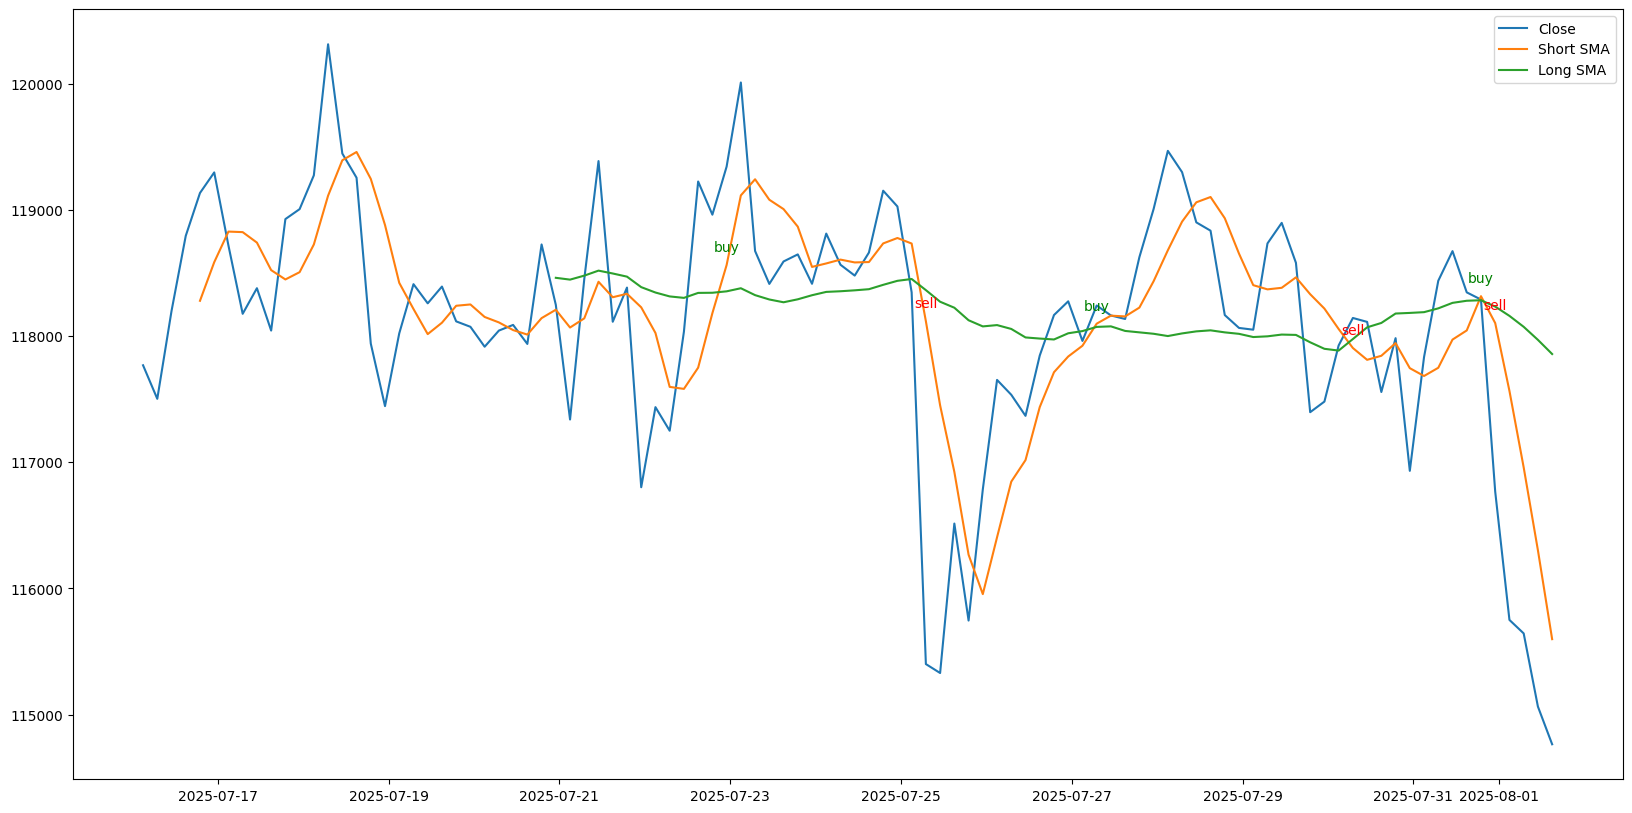

In [139]:
import matplotlib.pyplot as plt

# Example: data_sma has columns 'index', 'price', 'signal'
# 'signal' column contains 'buy', 'hold', or np.nan

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data_sma.index, df['close'], label='Close')

ax.plot(data_sma.index, data_sma['short_sma'], label='Short SMA')
ax.plot(data_sma.index, data_sma['long_sma'], label='Long SMA')

# Plot signals as text
for idx, row in data_sma.iterrows():
    if row['signals'] == 'buy':
        ax.annotate('buy', (idx, row['short_sma']), textcoords="offset points", xytext=(0,10), ha='center', color='green')
    elif row['signals'] == 'sell':
        ax.annotate('sell', (idx, row['short_sma']), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.legend()
plt.show()

In [253]:
orders = df_merged[(df_merged['signals'] == 'sell') | (df_merged['signals'] == 'buy')]
orders['quantity'] = 20000 / orders['close'] * ((orders['sma_diff'] > 0))
orders['pnl'] = (orders['quantity'] * (orders['close'].shift(-1) - orders['close'])).shift(1).fillna(0) # * ((orders['sma_diff'] < 0) * 2 - 1)).fillna(0)
orders['pnl'] = 100000 + orders['pnl'].cumsum()
orders['%'] = ((orders['pnl'] / 100000) - 1) * 100
orders 

C:\Users\huynh.th\AppData\Local\Temp\ipykernel_14760\3257068836.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\huynh.th\AppData\Local\Temp\ipykernel_14760\3257068836.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\huynh.th\AppData\Local\Temp\ipykernel_14760\3257068836.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,symbol,open,high,low,close,volume,short_sma,long_sma,sma_diff,signals,quantity,pnl,%
datetime,,,,,,,,,,,,,
2025-07-22 23:00:00,Bitstamp:BTCUSD,118966.0,120247.0,118483.0,119344.0,249.865066,118563.6,118355.166667,208.433333,buy,0.167583,100000.000000,0.000000
2025-07-25 07:00:00,Bitstamp:BTCUSD,118400.0,118509.0,115369.0,115400.0,1357.986626,118118.2,118364.766667,-246.566667,sell,0.000000,99339.053492,-0.660947
2025-07-27 07:00:00,Bitstamp:BTCUSD,117983.0,118397.0,117888.0,118243.0,82.557830,118098.8,118073.200000,25.600000,buy,0.169143,99339.053492,-0.660947
2025-07-30 07:00:00,Bitstamp:BTCUSD,117926.0,118241.0,117421.0,118144.0,108.201692,117905.8,117976.966667,-71.166667,sell,0.000000,99322.308315,-0.677692
2025-07-31 19:00:00,Bitstamp:BTCUSD,118346.0,118654.0,117811.0,118290.0,307.464430,118316.8,118284.566667,32.233333,buy,0.169076,99322.308315,-0.677692
2025-07-31 23:00:00,Bitstamp:BTCUSD,118290.0,118867.0,116739.0,116767.0,241.748484,118103.4,118234.266667,-130.866667,sell,0.000000,99064.805568,-0.935194


In [255]:
orders[orders.index == '2025-07-31 19:00:00']

,symbol,open,high,low,close,volume,short_sma,long_sma,sma_diff,signals,quantity,pnl,%
datetime,,,,,,,,,,,,,
2025-07-31 19:00:00,Bitstamp:BTCUSD,118346.0,118654.0,117811.0,118290.0,307.46443,118316.8,118284.566667,32.233333,buy,0.169076,99322.308315,-0.677692


### lightweigtschart

In [ ]:
# print("Initializing TradingViewData...")
# request = TradingViewData()
# print("Fetching data from TradingView...")
# df = request.get_hist(symbol='VHC',exchange='HOSE',interval=Interval.daily,n_bars=1000) \
#             .drop(columns=['symbol']) \
#             .reset_index(drop=False)
# df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
# df['date'] = df.date.dt.date
# # df.to_csv('data/VHC.csv', index=False)
# print("Data fetched successfully!")
# print("Data shape:", df.shape)
# df.head()

In [ ]:
# chart = JupyterChart()
# chart.set(df)
# chart.load()